### Load modules

In [34]:
import pandas as pd
import numpy as np
import os, re 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

#helper function for parsing the names later on
def parse_data(data):
    parsed_data = {}
    current_section = None
    for line in data.splitlines():
        # Check if the line starts a new section
        section_match = re.match(section_regex, line)
        if section_match:
            current_section = section_match.group().strip(':')
            parsed_data[current_section] = []
        elif current_section:  # Add billboard data to the current section
            billboards = re.findall(billboard_regex, line)
            if billboards:
                parsed_data[current_section].extend(billboards)
    return parsed_data

# Regular expressions to identify the different sections
section_regex = r"(Participant ID:\s\w+|passed_billboard_index_list:|passed_fixated_first_list:|passed_fixated_incepted_list:|repeated_forgone_list:|forgone_list:|passed_list:|glanced_list:)"
billboard_regex = r"billboard_image_\d+"

#### Setting up subjects and result data frame

In [35]:
sub_list = [f'sub{str(i).zfill(3)}' for i in range(1, 41)]
n_subs = len(sub_list)
print(sub_list[:3])

['sub001', 'sub002', 'sub003']


In [36]:
result_df = pd.DataFrame(np.zeros((40, 6)), columns = ['subj', 'condition',
                                                        'billboard_name', 'viewing_status', 
                                                        'recall_status', 'recognition_status' ])

result_df.tail(3)

,subj,condition,billboard_name,viewing_status,recall_status,recognition_status
37,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
result_df_list = []
condition_vector = []

for current_subject in  sub_list:
    #print(current_subject)
       
    #### Set up the file names to be read for this subject
    position_names_file        = '../data/01_gaze_data/' + current_subject + '_billboard_list_position_name_assignment.csv'
    passing_viewing_list_file  = '../data/01_gaze_data/' + current_subject + '_lists_1.txt'
    recall_file                = '../data/03_interview_qualtrics_data/recall_sheet.csv'
    recognition_file           = '../data/03_interview_qualtrics_data/recognition_sheet.csv'
    
    #######################################################################################
    
    #### Reading the position_name file
    #### this gives us the "raw names" of which billboards were for this ppt at which position, which will be used to relabel the output files.
    df_position_names  = pd.read_csv(position_names_file)
    df_position_names['billboard_name_at_position_cleaned'] = df_position_names['billboard_image_at_position'].apply(lambda x: x.replace("resources/billboards/", "").replace(".bmp", ""))
    df_dropped = df_position_names.drop(['index', 'position_index', 'billboard_image_at_position'], axis=1)
    mapping_dict = pd.Series(df_dropped['billboard_name_at_position_cleaned'].values, index=df_dropped['billboard_named_position']).to_dict()
    
    #######################################################################################
    
    #### Reading the file with the remembered billboards
    #### This gives us the behavioral information, i.e. which bbs were looked at, not looked at, incepted, etc.
    with open(passing_viewing_list_file, 'r', encoding='utf-8') as file:
        data = file.read()
    parsed_data = parse_data(data)
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in parsed_data.items()])) # Convert to a DataFrame (optional)
    
    passed_fixated_first_list = df['passed_fixated_first_list'].dropna()
    passed_fixated_first_list = list(passed_fixated_first_list.values)
    passed_fixated_first_list = [mapping_dict.get(item, item) for item in passed_fixated_first_list]
    
    passed_fixated_incepted_list = df['passed_fixated_incepted_list'].dropna()
    passed_fixated_incepted_list = list(passed_fixated_incepted_list.values)
    passed_fixated_incepted_list = [mapping_dict.get(item, item) for item in passed_fixated_incepted_list]
    
    repeated_forgone_list = df['repeated_forgone_list'].dropna()
    repeated_forgone_list = list(repeated_forgone_list.values)
    repeated_forgone_list = [mapping_dict.get(item, item) for item in repeated_forgone_list]
    
    forgone_list = df['forgone_list'].dropna()
    forgone_list = list(forgone_list.values)
    forgone_list = [mapping_dict.get(item, item) for item in forgone_list]
    
    passed_list = df['passed_list'].dropna()
    passed_list = list(passed_list.values)
    passed_list = [mapping_dict.get(item, item) for item in passed_list]
    
    glanced_list = df['glanced_list'].dropna()
    glanced_list = list(glanced_list.values)
    glanced_list = [mapping_dict.get(item, item) for item in glanced_list]
    
    # Create a list of lists and then a DataFrame from the list of lists
    all_lists = [passed_fixated_first_list, passed_fixated_incepted_list, repeated_forgone_list, forgone_list]
    result_df = pd.DataFrame( [item for sublist in all_lists for item in sublist], columns=['billboard'])
    
    result_df['viewing_status'] = ( ['passed_first_fixated'] * len(passed_fixated_first_list) +  
                                    ['passed_incept_fixated'] * len(passed_fixated_incepted_list) +  
                                    ['passed_incept_notfixated_forgone'] * len(repeated_forgone_list) + 
                                    ['passed_first_notfixated_forgone'] * len(forgone_list) )

    fixated_list = passed_fixated_first_list + passed_fixated_incepted_list
    result_df['fixated']  = [1 if item in fixated_list else 0 for item in result_df['billboard']]
    
    result_df['glanced']  = [1 if item in glanced_list else 0 for item in result_df['billboard']]

    #######################################################################################
    
    #### Reading the recall data file
    recall_df              = pd.read_csv(recall_file)
    this_sub_df            = recall_df[recall_df['subject'] == current_subject]
    this_sub_recalled      = this_sub_df.columns[this_sub_df.iloc[0] == 1].tolist()
    result_df['condition'] = this_sub_df['condition'].values[0]
    condition_vector.append(this_sub_df['condition'].values[0])
    result_df['recalled']  = [1 if item in this_sub_recalled else 0 for item in result_df['billboard']]
    
    #######################################################################################
    
    #### Reading the Recognition Data
    recognition_df          = pd.read_csv(recognition_file)
    this_sub_df             = recognition_df[recognition_df['subject'] == current_subject]
    this_sub_recognized     = this_sub_df.columns[this_sub_df.iloc[0] == 1].tolist()
    result_df['recognized'] = [1 if item in this_sub_recognized else 0 for item in result_df['billboard']]
    result_df['subject']    = current_subject

    #reorder, append, and delete
    result_df = result_df[['subject', 'condition', 'billboard', 'viewing_status', 'fixated', 'glanced', 'recalled', 'recognized']]
    result_df_list.append(result_df)
    del result_df


# Concatenate the DataFrames vertically
all_sub_df = pd.concat(result_df_list, ignore_index=True)
all_sub_df

,subject,condition,billboard,viewing_status,fixated,glanced,recalled,recognized
0,sub001,Free_Viewing,lawyer,passed_first_fixated,1,1,0,0
1,sub001,Free_Viewing,texting_driving,passed_first_fixated,1,1,1,1
2,sub001,Free_Viewing,burger,passed_first_fixated,1,1,0,0
3,sub001,Free_Viewing,binge_drinking,passed_first_fixated,1,1,0,1
4,sub001,Free_Viewing,employee_wellness,passed_first_fixated,1,1,0,1
...,...,...,...,...,...,...,...,...
970,sub040,Count_trash_bins,furniture,passed_first_notfixated_forgone,0,1,0,0
971,sub040,Count_trash_bins,great_lakes,passed_first_notfixated_forgone,0,0,0,0
972,sub040,Count_trash_bins,moving_business,passed_first_notfixated_forgone,0,0,0,0
973,sub040,Count_trash_bins,caffeine_consumption,passed_first_notfixated_forgone,0,0,0,0


In [38]:
all_sub_df.to_csv('../data/04_statistics/item_level_results.csv')


In [39]:
result = all_sub_df.groupby(['subject', 'viewing_status']).size().reset_index(name='count')
result

,subject,viewing_status,count
0,sub001,passed_first_fixated,17
1,sub001,passed_first_notfixated_forgone,7
2,sub001,passed_incept_fixated,7
3,sub002,passed_first_fixated,3
4,sub002,passed_first_notfixated_forgone,8
...,...,...,...
130,sub039,passed_incept_fixated,2
131,sub040,passed_first_fixated,3
132,sub040,passed_first_notfixated_forgone,9
133,sub040,passed_incept_fixated,5


In [40]:
pivot_table = result.pivot_table(index='subject', columns='viewing_status', values='count', fill_value=0)
pivot_table['condition'] = condition_vector
pivot_table

viewing_status,passed_first_fixated,passed_first_notfixated_forgone,passed_incept_fixated,passed_incept_notfixated_forgone,condition
subject,,,,,
sub001,17,7,7,0,Free_Viewing
sub002,3,8,5,3,Count_trash_bins
sub003,28,2,5,0,Free_Viewing
sub004,1,14,0,5,Count_trash_bins
sub005,16,7,6,0,Free_Viewing
sub006,8,11,5,1,Free_Viewing
sub007,30,3,3,0,Free_Viewing
sub008,5,15,2,2,Count_trash_bins
sub009,25,8,3,0,Free_Viewing


In [41]:
print(pivot_table['passed_first_fixated'].mean())
pivot_table['passed_first_fixated'].std()

11.2


10.785079912450751

In [42]:
pivot_table.groupby('condition').mean()

viewing_status,passed_first_fixated,passed_first_notfixated_forgone,passed_incept_fixated,passed_incept_notfixated_forgone
condition,,,,
Count_trash_bins,3.05,9.30,2.40,3.95
Free_Viewing,19.35,6.05,4.05,0.60


In [43]:
df_fv = pivot_table[pivot_table['condition'] == "Free_Viewing"]
df_fv


column_order = ['passed_first_notfixated_forgone', 'passed_first_fixated', 'passed_incept_fixated', 'passed_incept_notfixated_forgone']  # Desired order
df_fv = df_fv[column_order]

df_fv = df_fv.sort_values(by='passed_first_notfixated_forgone', ascending = True)
df_fv['sum'] = df_fv['passed_first_notfixated_forgone'] +  df_fv['passed_first_fixated'] +  df_fv['passed_incept_fixated'] +  df_fv['passed_incept_notfixated_forgone'] 
df_fv = df_fv.sort_values(by='sum', ascending = False)
df_fv = df_fv.drop(columns=['sum'])
df_fv = df_fv.sort_values(by='passed_first_notfixated_forgone', ascending = False)


df_fv.head()

viewing_status,passed_first_notfixated_forgone,passed_first_fixated,passed_incept_fixated,passed_incept_notfixated_forgone
subject,,,,
sub013,13,0,1,5
sub025,11,5,2,3
sub006,11,8,5,1
sub033,9,24,3,0
sub009,8,25,3,0


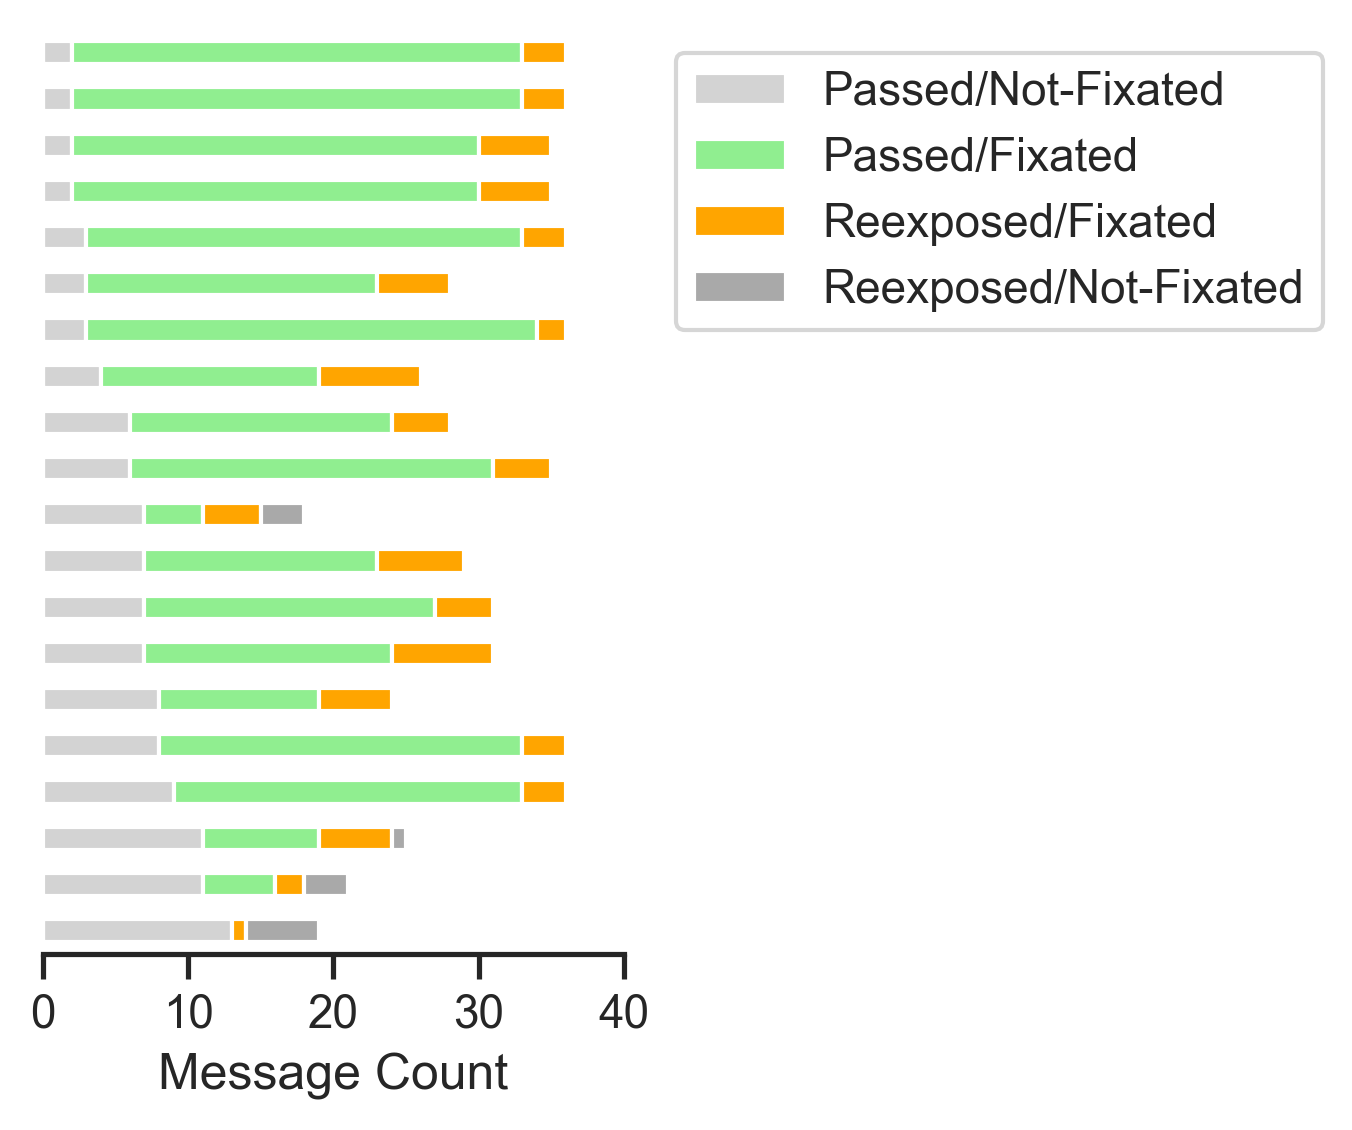

In [44]:
fig, ax = plt.subplots(figsize=(2.5, 4), dpi=300)  # Adjust size and resolution

df_fv.plot(kind="barh", stacked=True, color=("lightgrey", "lightgreen", "orange", "darkgrey"), ax = ax)
ax.yaxis.set_visible(False)  # Hide the y-axis and labels

#plt.ylabel('Sub')
plt.xlabel('Message Count')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Passed/Not-Fixated','Passed/Fixated','Reexposed/Fixated','Reexposed/Not-Fixated']
#plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1))  # Reverse order with [::-1]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1))  # Reverse order with [::-1]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(0, 40)
plt.show()

### same for countr trash bins

In [45]:
df_ctb = pivot_table[pivot_table['condition'] == "Count_trash_bins"]

column_order = ['passed_first_notfixated_forgone', 'passed_first_fixated', 'passed_incept_fixated', 'passed_incept_notfixated_forgone']  # Desired order
df_ctb = df_ctb[column_order]

df_ctb = df_ctb.sort_values(by='passed_first_notfixated_forgone', ascending = True)
df_ctb['sum'] = df_ctb['passed_first_notfixated_forgone'] +  df_ctb['passed_first_fixated'] +  df_ctb['passed_incept_fixated'] +  df_ctb['passed_incept_notfixated_forgone'] 
df_ctb = df_ctb.sort_values(by='sum', ascending = False)
df_ctb = df_ctb.drop(columns=['sum'])
df_ctb = df_ctb.sort_values(by='passed_first_notfixated_forgone', ascending = False)

df_fv.head()

viewing_status,passed_first_notfixated_forgone,passed_first_fixated,passed_incept_fixated,passed_incept_notfixated_forgone
subject,,,,
sub013,13,0,1,5
sub025,11,5,2,3
sub006,11,8,5,1
sub033,9,24,3,0
sub009,8,25,3,0


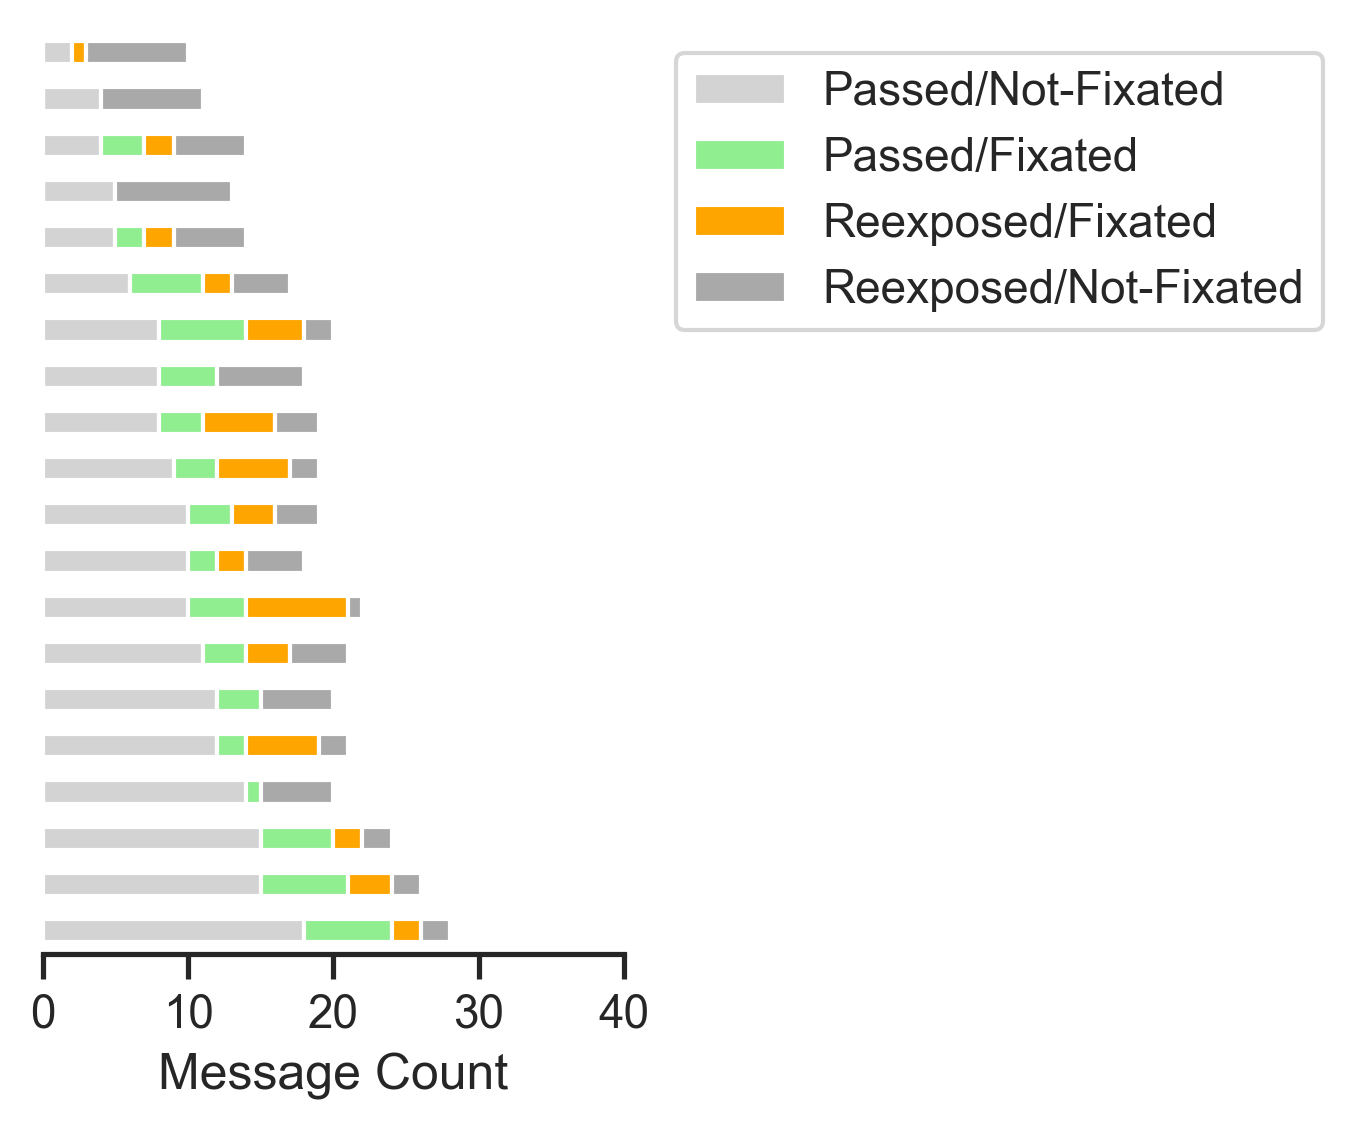

In [46]:
fig, ax = plt.subplots(figsize=(2.5, 4), dpi=300)  # Adjust size and resolution

df_ctb.plot(kind="barh", stacked=True, color=("lightgrey", "lightgreen", "orange", "darkgrey"), ax = ax)
ax.yaxis.set_visible(False)  # Hide the y-axis and labels

#plt.ylabel('Sub')
plt.xlabel('Message Count')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Passed/Not-Fixated','Passed/Fixated','Reexposed/Fixated','Reexposed/Not-Fixated']
#plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1))  # Reverse order with [::-1]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1))  # Reverse order with [::-1]

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(0, 40)
plt.show()

### Plot attempts

In [47]:
all_sub_df.head(40)

,subject,condition,billboard,viewing_status,fixated,glanced,recalled,recognized
0,sub001,Free_Viewing,lawyer,passed_first_fixated,1,1,0,0
1,sub001,Free_Viewing,texting_driving,passed_first_fixated,1,1,1,1
2,sub001,Free_Viewing,burger,passed_first_fixated,1,1,0,0
3,sub001,Free_Viewing,binge_drinking,passed_first_fixated,1,1,0,1
4,sub001,Free_Viewing,employee_wellness,passed_first_fixated,1,1,0,1
5,sub001,Free_Viewing,moving_business,passed_first_fixated,1,1,0,0
6,sub001,Free_Viewing,mental_health,passed_first_fixated,1,1,0,0
7,sub001,Free_Viewing,healthy_diet,passed_first_fixated,1,1,0,1
8,sub001,Free_Viewing,fundraising,passed_first_fixated,1,1,0,0
9,sub001,Free_Viewing,carpet_cleaning,passed_first_fixated,1,1,0,0


In [48]:
# Create a binary variable for the outcome (Recall or Recognition, depending on what you want to emphasize)
#all_sub_df['outcome'] = all_sub_df['recalled'].map({0: 'Failure', 1: 'Success'})  # For recall, for example
#all_sub_df.head(40)

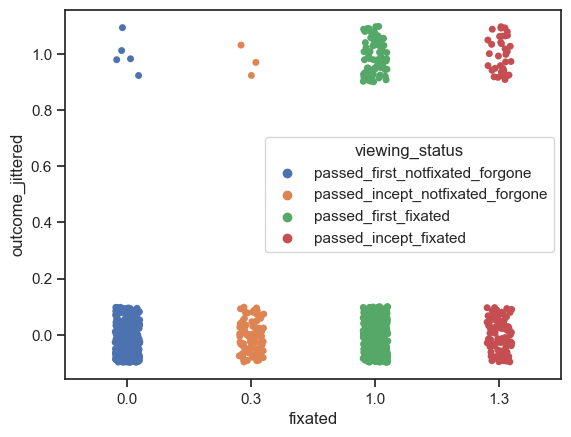

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42) 
all_sub_df['outcome_jittered'] = all_sub_df['recalled'] + np.random.uniform(-0.1, 0.1, size=len(all_sub_df))
all_sub_df['fixated'] += 0.3 * ((all_sub_df['viewing_status'] == 'passed_incept_fixated') | (all_sub_df['viewing_status'] == 'passed_incept_notfixated_forgone'))


# Create a swarm plot
sns.stripplot(x='fixated', y='outcome_jittered', hue='viewing_status', data=all_sub_df, jitter=True)

#sns.stripplot(x='var1', y='outcome', hue='var2', data=df)
plt.show()